In [ ]:
import os
import gc
import sys
import torch
import psutil
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models, set_image_backend

import data_utils
import train_utils
import model_utils

import copy

In [8]:
# setup
set_image_backend('accimage')
device = torch.device('cuda', 0)

# load sample annotations pickle
pickle_file = '/home/sxchao/MSI_prediction/tcga_project/tcga_wgd_sa_all.pkl'
batch_all, _, _, sa_trains, sa_vals = data_utils.load_COAD_train_val_sa_pickle(pickle_file=pickle_file,
                                                                               return_all_cancers=True, 
                                                                               split_in_two=True)
# normalize and tensorify jpegs
val_transform = train_utils.transform_validation

# initialize Datasets
val_sets = []
val_cancers = ['UCEC', 'LIHC_10x', 'KIRC_10x']
magnification = '10.0'
root_dir = '/n/mounted-data-drive/'
for j in range(len(val_cancers)):
    val_set = data_utils.TCGADataset_tiles(sa_vals[batch_all.index(val_cancers[j])], 
                                           root_dir + val_cancers[j] + '/', 
                                           transform=val_transform, 
                                           magnification=magnification, 
                                           batch_type='tile', 
                                           return_jpg_to_sample=True)
    val_sets.append(val_set)

# get DataLoaders    
batch_size_val = 400
n_workers = 16
val_loaders = [torch.utils.data.DataLoader(val_set, 
                                        batch_size=batch_size_val, 
                                        shuffle=True, 
                                        num_workers=n_workers, 
                                        pin_memory=True) for val_set in val_sets]

In [ ]:
# model args
state_dict_file_resnet = '/n/tcga_models/resnet18_WGD_all_10x.pt'
state_dict_file_maml = '/n/tcga_models/maml_WGD_10x_v02a.pt'
input_size = 2048
hidden_size = 512
output_size = 1

# initialize trained resnet
resnet = models.resnet18(pretrained=False)
resnet.fc = nn.Linear(2048, output_size, bias=True)
saved_state = torch.load(state_dict_file_resnet, map_location=lambda storage, loc: storage)
resnet.load_state_dict(saved_state)

# freeze layers
resnet.fc = model_utils.Identity()
resnet.cuda(device=device)
for param in resnet.parameters():
    param.requires_grad = False
    
# initialize theta_global
net = model_utils.FeedForward(input_size, hidden_size, output_size)
saved_state = torch.load(state_dict_file_maml, map_location=lambda storage, loc: storage)
net.load_state_dict(saved_state)
net.cuda(device=device)

In [ ]:
theta_global = [p.detach().clone() for p in net.parameters()]

In [ ]:
resnet.eval()
num_steps = 10
#num_tasks = int(tiles.shape[1])
#for t in range(num_tasks):
all_losses = np.zeros((num_steps, len(val_loaders[0])))

In [9]:
alpha = 1e-2
criterion_mean = nn.BCEWithLogitsLoss()
criterion_none = nn.BCEWithLogitsLoss(reduction = 'none')
optimizer = torch.optim.Adam(net.parameters(), lr = alpha)

In [ ]:
for cancer_num, val_loader in enumerate(val_loaders):
    all_logits = []
    all_labels = []
    all_types = []
    all_jpgs = []
    for batch_num,(tiles,labels,jpg_to_sample) in enumerate(val_loader):
        print(batch_num, end=' ')
        for step in range(num_steps): 
            optimizer.zero_grad()
            if step == 0:
                net.eval()
                tiles, labels = tiles.cuda(), labels.cuda().float()
                idx = int(tiles.shape[0] / 2)
                inputs_a = tiles[:idx,:,:,:]
                inputs_b = tiles[idx:,:,:,:]
                labels_a = labels[:idx].unsqueeze(1)
                labels_b = labels[idx:].unsqueeze(1)    

                output_b = net(resnet(inputs_b))
                logits = output_b.contiguous().view(-1).float().detach().cpu().numpy()
                labels = labels_b.contiguous().view(-1).detach().cpu().numpy()
                jpg_to_sample = jpg_to_sample[idx:].view(-1).float().numpy()
                
                all_logits.extend(logits)
                all_labels.extend(labels)
                all_types.extend([cancer_num] * idx)
                all_jpgs.extend(jpg_to_sample)

                loss = criterion(output_b, labels_b)
                all_losses[step, batch_num] = loss.detach().cpu().item()
            else:
                # first forward pass, step 
                net.train()
                output_a = net(resnet(inputs_a))
                loss = criterion(output_a, labels_a)
                loss.backward()
                optimizer.step()            
                # second forward pass   
                net.eval()
                output_b = net(resnet(inputs_b))
                loss = criterion(output_b, labels_b)
                #all_losses[step, batch_num] = loss.detach().cpu().item()
        print(all_losses[:,batch_num])
        #net.linear1.weight.data = theta_global[0].clone()
        #net.linear1.bias.data = theta_global[1].clone()
        #net.linear2.weight.data = theta_global[2].clone()
        #net.linear2.bias.data = theta_global[3].clone()
        net.update_params(theta_global)

In [10]:
criterion = nn.BCEWithLogitsLoss(reduction='none')

In [12]:
for cancer_num, val_loader in enumerate(val_loaders):
    for batch_num,(tiles,labels,jpg_to_sample) in enumerate(val_loader):
        break
    break

In [13]:
tiles, labels = tiles.cuda(), labels.cuda().float()
idx = int(tiles.shape[0] / 2)
inputs_a = tiles[:idx,:,:,:]
inputs_b = tiles[idx:,:,:,:]
labels_a = labels[:idx].unsqueeze(1)
labels_b = labels[idx:].unsqueeze(1)    

In [14]:
#for step in range(num_steps):        
#    optimizer.zero_grad()
#    if step == 0:
resnet.eval()
net.eval()
output_b = net(resnet(inputs_b))
loss = criterion(output_b, labels_b)
loss.shape

torch.Size([200, 1])

In [15]:
#all_losses[step, batch_num] = loss.detach().cpu().item()
logits = output_b.contiguous().view(-1).float().detach().cpu().numpy()
labels = labels_b.contiguous().view(-1).detach().cpu().numpy()
jpg_to_sample = jpg_to_sample[idx:].view(-1).float().numpy()
logits.shape, labels.shape, jpg_to_sample.shape

((200,), (200,), (200,))

In [17]:
all_logits = []
all_labels = []
all_types = []
all_jpgs = []

In [20]:
all_logits.extend(logits)
all_labels.extend(labels)
all_types.extend([cancer_num] * idx)
all_jpgs.extend(jpg_to_sample)

In [21]:
d = {'label': all_labels, 'logit': all_logits, 'type': all_types, 'sample': all_jpgs}
df = pd.DataFrame(data = d)
df.head(5)

,label,logit,type,sample
0,0.0,-68.785934,0,23.0
1,0.0,-17.854445,0,13.0
2,0.0,0.139046,0,24.0
3,0.0,-6.839326,0,49.0
4,1.0,140.686630,0,16.0


In [24]:
df2 = df.groupby(['type','sample'])['label','logit'].mean().round()
df2.head(5)

label  logit
type sample              
0    0.0       0.0 -118.0
     1.0       0.0  -53.0
     2.0       1.0   60.0
     3.0       0.0  -87.0
     4.0       0.0  -76.0

In [54]:
loss = criterion(torch.tensor(df2['logit'].values, device=device), torch.tensor(df2['label'].values, device=device))
loss

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.2204e-16, 9.1147e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.9145e-13, 2.7895e-10, 0.0000e+00, 1.8796e-12, 0.0000e+00, 0.0000e+00,
        1.2340e-04, 3.3541e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.4000e+01, 0.0000e+00, 3.9000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 6.0025e+00, 6.3000e+01, 0.0000e+00, 0.0000e+00, 3.8000e+01,
        0.0000e+00, 0.0000e+00, 5.8000e+01, 0.0000e+00, 7.7000e+01, 1.6702e-05,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2000e+01], device='cuda:0',
       dtype=torch.float64)

In [55]:
torch.std(loss)

tensor(18.1343, device='cuda:0', dtype=torch.float64)

In [56]:
torch.mean(loss)

tensor(6.8914, device='cuda:0', dtype=torch.float64)

In [57]:
torch.median(loss)

tensor(0., device='cuda:0', dtype=torch.float64)

In [58]:
torch.exp(-loss)

tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 9.9909e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        9.9988e-01, 9.9966e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 3.7751e-11, 1.0000e+00, 1.1548e-17, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.4726e-03, 4.3596e-28, 1.0000e+00, 1.0000e+00, 3.1391e-17,
        1.0000e+00, 1.0000e+00, 6.4702e-26, 1.0000e+00, 3.6251e-34, 9.9998e-01,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 6.1442e-06], device='cuda:0',
       dtype=torch.float64)

In [42]:
loss = criterion(output_b.squeeze(), labels_b.squeeze())
loss

tensor([0.0000e+00, 0.0000e+00, 7.6509e-01, 1.0703e-03, 0.0000e+00, 0.0000e+00,
        2.6226e-06, 0.0000e+00, 0.0000e+00, 7.3725e+01, 0.0000e+00, 2.4173e-01,
        0.0000e+00, 5.1260e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.0036e+01, 4.8427e+00, 2.9313e+01, 8.8214e-06, 8.7949e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.1984e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.8550e+01, 0.0000e+00, 4.9792e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        7.7136e+01, 0.0000e+00, 1.1921e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0154e+01, 0.0000e+00, 3.2358e+01, 4.0903e+01,
        5.6804e+01, 0.0000e+00, 3.7832e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4305e-06,
        0.0000e+00, 0.0000e+00, 0.0000e+

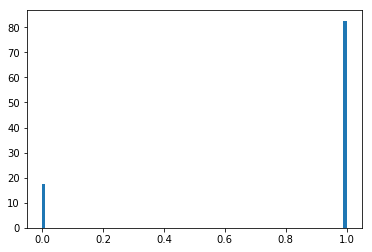

In [62]:
import matplotlib.pyplot as plt

plt.hist(torch.exp(-loss).detach().cpu().numpy(), bins=100, density=True)
plt.show()

In [92]:
all_logits = []
all_labels = []
all_types = []
all_jpgs = []

net.eval()
cancer_num = 0
for batch_num,(tiles,labels,jpg_to_sample) in enumerate(val_loaders[1]):
    print(batch_num, end=' ')
    tiles, labels = tiles.cuda(), labels.cuda().float()
    idx = int(tiles.shape[0] / 2)
    #inputs_a = tiles[:idx,:,:,:]
    inputs_b = tiles[idx:,:,:,:]
    #labels_a = labels[:idx].unsqueeze(1)
    labels_b = labels[idx:].unsqueeze(1)    

    output_b = net(resnet(inputs_b))
    logits = output_b.contiguous().view(-1).float().detach().cpu().numpy()
    labels = labels_b.contiguous().view(-1).detach().cpu().numpy()
    jpg_to_sample = jpg_to_sample[idx:].view(-1).float().numpy()

    all_logits.extend(logits)
    all_labels.extend(labels)
    all_types.extend([cancer_num] * round(tiles.shape[0] / 2))
    all_jpgs.extend(jpg_to_sample)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [93]:
len(all_labels), len(all_logits), len(all_types), len(all_jpgs)

(59912, 59912, 59912, 59912)

In [94]:
d = {'label': all_labels, 'logit': all_logits, 'type': all_types, 'sample': all_jpgs}
df = pd.DataFrame(data = d)
df2 = df.groupby(['type','sample'])['label','logit'].mean().round()
df2

label  logit
type sample              
0    0.0       1.0  -88.0
     1.0       0.0  -60.0
     2.0       0.0 -104.0
     3.0       0.0  -85.0
     4.0       0.0  -64.0
     5.0       1.0  -43.0
     6.0       0.0 -112.0
     7.0       1.0  -22.0
     8.0       0.0  -72.0
     9.0       0.0 -104.0
     10.0      1.0  -56.0
     11.0      1.0  -85.0
     12.0      0.0  -75.0
     13.0      0.0 -126.0
     14.0      1.0  -69.0
     15.0      0.0 -105.0
     16.0      0.0 -107.0
     17.0      1.0  -98.0
     18.0      0.0  -62.0
     19.0      0.0  -37.0
     20.0      0.0  -60.0
     21.0      1.0  -63.0
     22.0      0.0  -55.0
     23.0      1.0  -56.0
     24.0      1.0  -67.0
     25.0      0.0 -120.0
     26.0      1.0  -56.0
     27.0      1.0  -91.0
     28.0      0.0  -62.0
     29.0      0.0  -46.0
     30.0      1.0  -48.0
     31.0      1.0 -145.0
     32.0      0.0  -84.0
     33.0      0.0 -106.0
     34.0      0.0  -81.0
     35.0      0.0 -115.0

In [95]:
loss = criterion(torch.tensor(df2['logit'].values, device=device), torch.tensor(df2['label'].values, device=device))

(array([22.,  1.,  1.,  4.,  3.,  1.,  3.,  0.,  0.,  1.]),
 array([  0. ,  14.5,  29. ,  43.5,  58. ,  72.5,  87. , 101.5, 116. ,
        130.5, 145. ]),
 <a list of 10 Patch objects>)

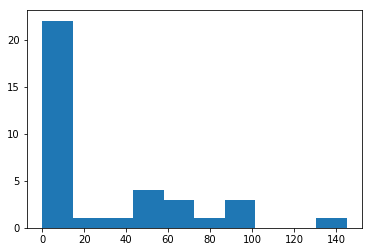

In [96]:
plt.hist(loss.detach().cpu().numpy())

In [97]:
df2['loss'] = loss.detach().cpu().numpy()

label
0.0    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
1.0    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
dtype: object

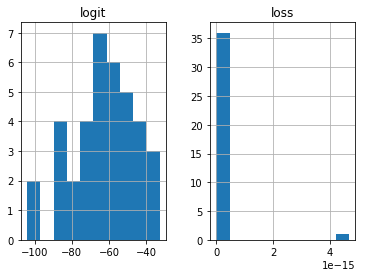

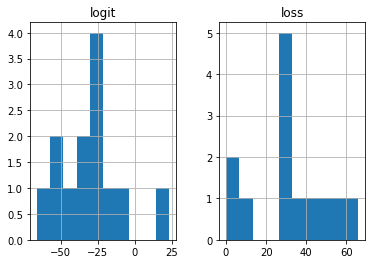

In [88]:
df2.groupby(['label']).hist()

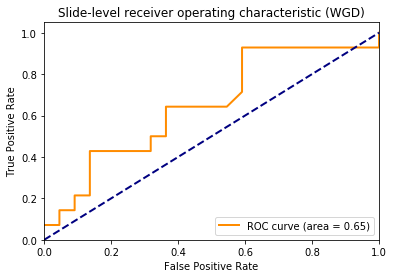

In [98]:
import scipy
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.array(df2['label']), scipy.special.expit(np.array(df2['logit'])))
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Slide-level receiver operating characteristic (WGD)')
plt.legend(loc="lower right")
plt.show()